## Import Packages

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from node2vec import Node2Vec
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import math
import random
import scipy.optimize as opt
import statistics
import community
from community import community_louvain
from sklearn.model_selection import train_test_split
import pickle

ModuleNotFoundError: No module named 'node2vec'

## Load Dataset

In [ ]:
df = pd.read_csv('full_context_PeerRead.csv')

In [ ]:
df.head(10)

,right_citated_text,left_citated_text,source_abstract,source_author,source_id,source_title,source_venue,source_year,target_id,target_author,target_abstract,target_year,target_title,target_venue
0,andsyntactic parsing .Because RNNs make very f...,We conducted additional experiments on artific...,Deep Neural Networks (DNNs) are powerful model...,ilya sutskever;oriol vinyals;quoc v le,1409.3215v1,Sequence to Sequence Learning with Neural Netw...,NIPS,2014.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
1,.Because RNNs make very few domain-specific as...,We conducted additional experiments on artific...,Syntactic parsing is a fundamental problem in ...,oriol vinyals;lukasz kaiser;terry koo;slav pet...,1412.7449v1,Grammar as a Foreign Language,NIPS,2014.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
2,"; in a Pointer Network,the only way to generat...","Reproducibility. All code, data, and experimen...",We introduce a new neural architecture to lear...,oriol vinyals;meire fortunato;navdeep jaitly,1506.03134v1,Pointer Networks,NIPS,2015.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
3,". Recently, nsur . have shown superior perfor...","st like CWS and POS tagging, automatic prosody...",The recently introduced continuous Skip-gram m...,tomas mikolov;ilya sutskever;kai chen 0010;gre...,1310.4546v1,Distributed Representations of Words and Phras...,NIPS,2013.0,1511.00360v1,chuang ding;lei xie;jie yan;weini zhang;yang liu,Prosody affects the naturalness and intelligib...,2015,Automatic Prosody Prediction for Chinese Speec...,arxiv
4,model trained on the Google News dataset3.In a...,We begin by considering a document as the set ...,The recently introduced continuous Skip-gram m...,tomas mikolov;ilya sutskever;kai chen 0010;gre...,1310.4546v1,Distributed Representations of Words and Phras...,NIPS,2013.0,1705.10900v1,paul michel;abhilasha ravichander;shruti rijhwani,We investigate the pertinence of methods from ...,2017,Does the Geometry of Word Embeddings Help Docu...,arxiv
5,". We observe that by themselves, Ph embeddings...","With GMM and Aw2v+Ph, the F1-Score of clusteri...",We report on a series of experiments with conv...,yoon kim,1408.5882v1,Convolutional Neural Networks for Sentence Cla...,EMNLP,2014.0,1705.10900v1,paul michel;abhilasha ravichander;shruti rijhwani,We investigate the pertinence of methods from ...,2017,Does the Geometry of Word Embeddings Help Docu...,arxiv
6,. We observe that Ph embeddings perform poorly...,We evaluate our method on the CSP dataset8. Th...,Many machine learning algorithms require the i...,quoc v le;tomas mikolov,1405.4053v1,Distributed Representations of Sentences and D...,ICML,2014.0,1705.10900v1,paul michel;abhilasha ravichander;shruti rijhwani,We investigate the pertinence of methods from ...,2017,Does the Geometry of Word Embeddings Help Docu...,arxiv
7,or purely word vector based methods . .cument...,We perform document-level binary sentiment cla...,Many machine learning algorithms require the i...,quoc v le;tomas mikolov,1405.4053v1,Distributed Representations of Sentences and D...,ICML,2014.0,1705.10900v1,paul michel;abhilasha ravichander;shruti rijhwani,We investigate the pertinence of methods from ...,2017,Does the Geometry of Word Embeddings Help Docu...,arxiv
8,. Two most popular approaches of DGM rely on v...,In the lack of sufficient health status inform...,The ever-increasing size of modern data sets c...,diederik p kingma;shakir mohamed;danilo jimene...,1406.5298v1,Semi-supervised Learning with Deep Generative ...,NIPS,2014.0,1709.00845v1,andre s yoon;taehoon lee;yongsub lim;deokwoo j...,This work presents a novel semi-supervised lea...,2017,Semi-supervised Learning with Deep Generative ...,arxiv
9,. Th

In [ ]:
df.iloc[0]['left_citated_text'] + df.iloc[0]['right_citated_text']

"We conducted additional experiments on artificial datato investigate the importance of adding longer, harder examples.We experimented with adding new examples via data recombination,as well as adding new independent examples e.g. to simulatethe acquisition of more training data.We constructed a simple world containing a set of entitiesand a set of binary relations.For any n, we can generate a set of depth-n examples,which involve the composition of n relationsapplied to a single entity.Example data points are shown in Figure 5.We train our model on various datasets,then test it on a set of 500 randomly chosen depth-2 examples.The model always has access to a small seed training set of 100 depth-2 examples.We then add one of four types of examples to the training set:me length, independent: New randomly chosen depth-2 examples.3nger, independent: Randomly chosen depth-4 examples.me length, recombinant:Depth-2 examples sampled fromthe grammar induced by applying AbsEntities to the seed 

In [ ]:
print(len(df['target_title'].unique()))
print(len(df['source_title'].unique()))

3693
2444


## Create a Directed Graph

In [ ]:
def make_graph(edges, name=None, directed=0):
    """
    Input: list nodes, list edges consisting of tuples of integer node indices
    optional string name

    Output: networkx graph
    """
    if directed == 1:
        grph = nx.DiGraph()
    else:
        grph = nx.Graph()
    grph.add_edges_from(edges)
    if name:
        grph.name = name
    return grph

In [ ]:
# get a list of tuples with edges
edges_list = df.apply(lambda row: (row['source_title'], row['target_title']), axis=1).tolist()

# Create a directed graph
G =  make_graph(edges_list, directed=1)

### Check the number of edges and nodes

In [ ]:
print('Number of Nodes in G:',len(G.nodes))
print('Number of edges in G:',len(G.edges))

Number of Nodes in G: 4836
Number of edges in G: 12692


### Node Degree

- The degree kv of node v is the number of edges (neighboring nodes) the node has.
- Treats all neighboring nodes equally.

![image.png](attachment:image.png)


In [ ]:
# Node Degree
node_degrees = dict(G.degree())
node_degrees

{'Sequence to Sequence Learning with Neural Networks': 332,
 'Data Recombination for Neural Semantic Parsing': 11,
 'Grammar as a Foreign Language': 72,
 'Pointer Networks': 44,
 'Distributed Representations of Words and Phrases and their Compositionality': 412,
 'Automatic Prosody Prediction for Chinese Speech Synthesis using BLSTM-RNN and Embedding Features': 1,
 'Does the Geometry of Word Embeddings Help Document Classification? A Case Study on Persistent Homology Based Representations': 3,
 'Convolutional Neural Networks for Sentence Classification': 112,
 'Distributed Representations of Sentences and Documents': 102,
 'Semi-supervised Learning with Deep Generative Models': 33,
 'Semi-supervised Learning with Deep Generative Models for Asset Failure Prediction': 4,
 'Multi-Sensor Prognostics using an Unsupervised Health Index based on LSTM Encoder-Decoder': 4,
 'Ladder Variational Autoencoders': 4,
 'Adam: A Method for Stochastic Optimization': 536,
 'Do Deep Nets Really Need to be

In [ ]:
max(node_degrees.values())

536

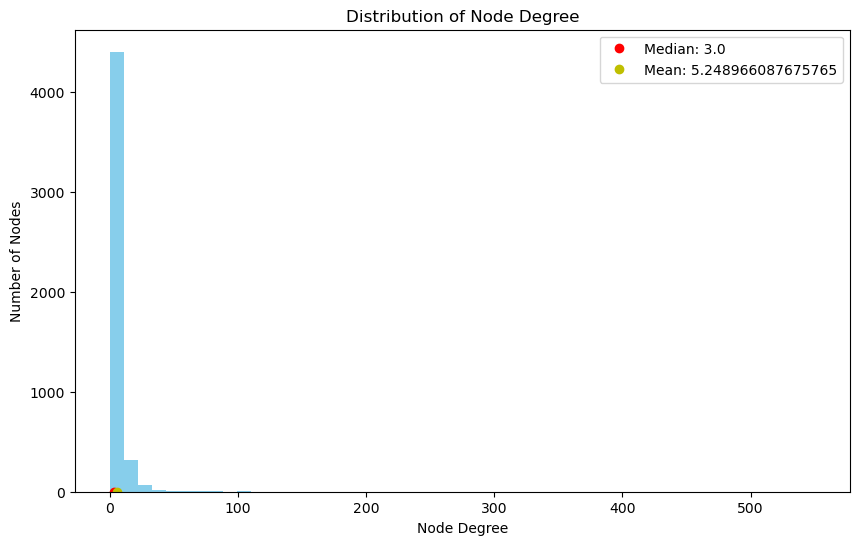

In [ ]:
degrees = list(node_degrees.values())
median_degree = statistics.median(degrees)
mean_degree = statistics.mean(degrees)


# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, range=(0, 550), color='skyblue')

# Plot the median as a red dot
plt.plot(median_degree, 1, 'ro', label=f'Median: {median_degree}')  # '1' is a basic y-value for the dot

# Plot the mean as a yellow dot
plt.plot(mean_degree, 1, 'yo', label=f'Mean: {mean_degree}')  # '1' is a basic y-value for the dot

plt.title('Distribution of Node Degree')
plt.xlabel('Node Degree')
plt.ylabel('Number of Nodes')
plt.legend()
plt.show()

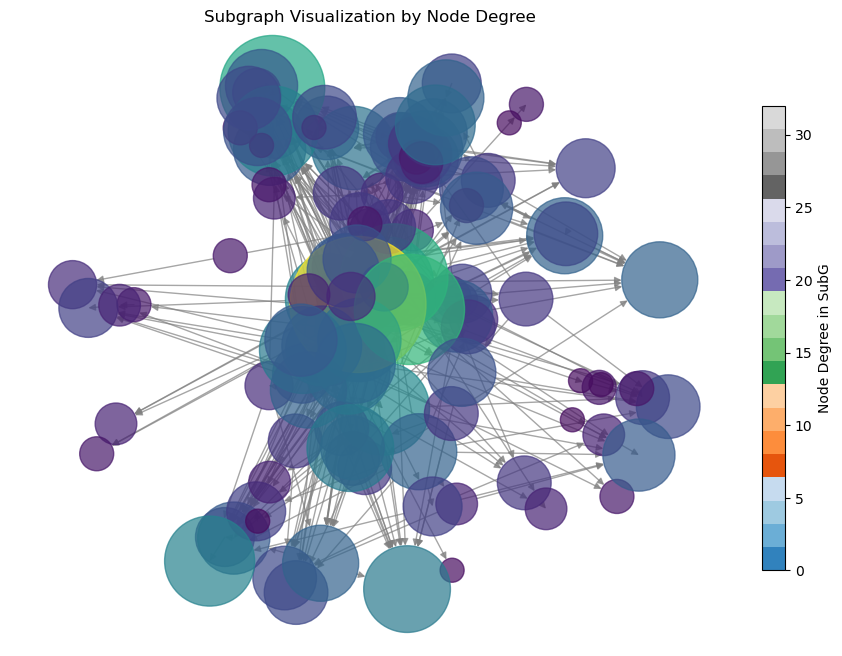

In [ ]:
# Identify high-degree nodes (threshold is set to 20 as an example)
high_degree_nodes = [node for node, degree in node_degrees.items() if degree > 20]

# Create a subgraph from G containing only the high-degree nodes
subG = G.subgraph(high_degree_nodes)

subG_node_degrees = dict(subG.degree())
subG_degrees = list(subG_node_degrees.values())

# Normalize node sizes based on degrees for visualization
subG_node_sizes = [degree * 300 for node, degree in subG_node_degrees.items()]

# Choose a layout for the nodes in the subgraph
pos_subG = nx.spring_layout(subG)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 8))

# Map degrees to colors in subG
# Normalize the colors to lie between 0 and 1 based on the node degrees
colors = [plt.cm.viridis(degree/max(subG_degrees)) for degree in subG_degrees]

# Draw the subgraph
nx.draw(subG, pos=pos_subG, ax=ax, node_size=subG_node_sizes, node_color=colors,
        with_labels=False, edge_color='gray', alpha=0.7)

# Create a color map based on the degree of the nodes
sm = plt.cm.ScalarMappable(cmap='tab20c', norm=plt.Normalize(vmin=min(subG_degrees), vmax=max(subG_degrees)))
sm.set_array([])  # You have to set the array for the ScalarMappable. It does not affect the colorbar.

# Create colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Node Degree in SubG')

plt.title('Subgraph Visualization by Node Degree')
plt.show()


### Clustering Coefficient

- Measures how connected v′s neighboring nodes are:<br>
  - ![image.png](attachment:image.png)

  - ![image-2.png](attachment:image-2.png)

In [ ]:
# Calculate the local clustering coefficient for all nodes
local_clustering = nx.clustering(G)
local_clustering

{'Sequence to Sequence Learning with Neural Networks': 0.005141411567721035,
 'Data Recombination for Neural Semantic Parsing': 0.11818181818181818,
 'Grammar as a Foreign Language': 0.01741001564945227,
 'Pointer Networks': 0.03171247357293869,
 'Distributed Representations of Words and Phrases and their Compositionality': 0.001801195285002244,
 'Automatic Prosody Prediction for Chinese Speech Synthesis using BLSTM-RNN and Embedding Features': 0,
 'Does the Geometry of Word Embeddings Help Document Classification? A Case Study on Persistent Homology Based Representations': 0.16666666666666666,
 'Convolutional Neural Networks for Sentence Classification': 0.01447876447876448,
 'Distributed Representations of Sentences and Documents': 0.007668413900213551,
 'Semi-supervised Learning with Deep Generative Models': 0.019886363636363636,
 'Semi-supervised Learning with Deep Generative Models for Asset Failure Prediction': 0,
 'Multi-Sensor Prognostics using an Unsupervised Health Index base

In [ ]:
max(local_clustering.values())

1.0

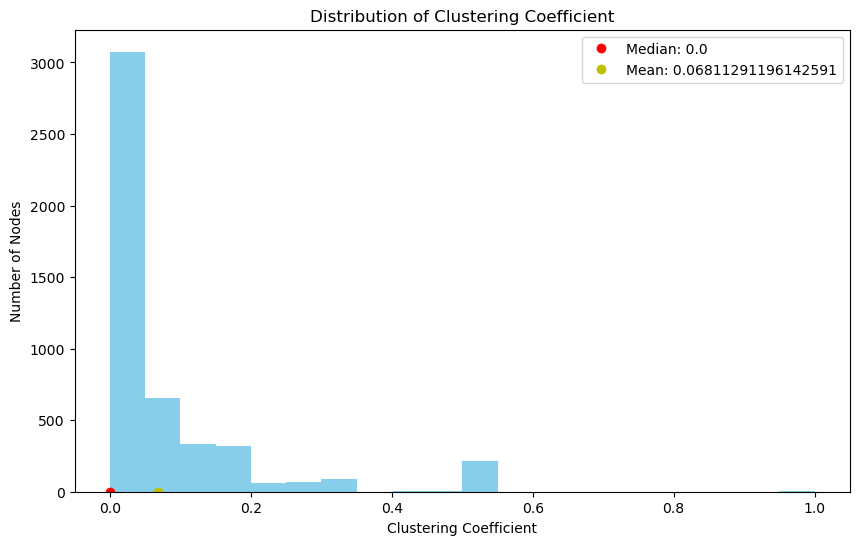

In [ ]:
# Calculate the average local clustering coefficient (global)
average_clustering = nx.average_clustering(G)

clustering = list(local_clustering.values())
median_clustering= statistics.median(clustering)

# Plot clustering coefficient distribution
plt.figure(figsize=(10, 6))
plt.hist(clustering, bins=20, range=(0,1), color='skyblue')

# Plot the median as a red dot
plt.plot(median_clustering, 1, 'ro', label=f'Median: {median_clustering}')  # '1' is a basic y-value for the dot

# Plot the mean as a yellow dot
plt.plot(average_clustering, 1, 'yo', label=f'Mean: {average_clustering}')  # '1' is a basic y-value for the dot

plt.title('Distribution of Clustering Coefficient')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of Nodes')
plt.legend()
plt.show()

### Density

Graph density is a measure that quantifies how close a graph is to being a complete graph, where a complete graph is one in which every pair of distinct vertices is connected by a unique edge.

For an undirected graph, the density $ D $ is defined as:
$ D = \frac{2E}{N(N-1)} $

And for a directed graph, the density is defined as:
$ D = \frac{E}{N(N-1)} $

Where:<br>
-  $ E $ is the number of edges in the graph. <br>
-  $ N $ is the number of nodes (vertices) in the graph.

In [ ]:
# Calculate the density
density = nx.density(G)
print(f"The density of the graph is: {density}")

The density of the graph is: 0.0005428093162022508


The graph density value of approximately 0.0005428093162022508 indicates that the graph is very sparse. <br><br>
This means that there are relatively few edges and the nodes are not highly interconnected.<br><br>
In practical terms, it suggests that the graph likely contains many isolated nodes or clusters with few connections between them, which is typical for large networks where not every node is directly connected to many others.

### PageRank

In [ ]:
# Run PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)  # alpha is the damping parameter (usually set to 0.85)
pagerank_scores

{'Sequence to Sequence Learning with Neural Networks': 0.00014132851682790526,
 'Data Recombination for Neural Semantic Parsing': 0.00013501346249703052,
 'Grammar as a Foreign Language': 0.00013229402554456134,
 'Pointer Networks': 0.00013799437895775147,
 'Distributed Representations of Words and Phrases and their Compositionality': 0.00013673915515624132,
 'Automatic Prosody Prediction for Chinese Speech Synthesis using BLSTM-RNN and Embedding Features': 0.00013043008101862894,
 'Does the Geometry of Word Embeddings Help Document Classification? A Case Study on Persistent Homology Based Representations': 0.00013354148085087836,
 'Convolutional Neural Networks for Sentence Classification': 0.00013342824900383965,
 'Distributed Representations of Sentences and Documents': 0.0002420349701493365,
 'Semi-supervised Learning with Deep Generative Models': 0.0001341068900191407,
 'Semi-supervised Learning with Deep Generative Models for Asset Failure Prediction': 0.00021764753990646097,
 'M

In [ ]:
max(pagerank_scores.values())

0.009185668193772391

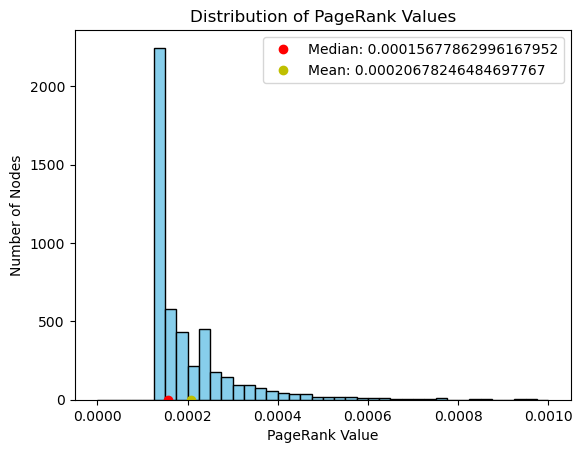

In [ ]:
pagerank = list(pagerank_scores.values())
median_pagerank  = statistics.median(pagerank)
mean_pagerank  = statistics.mean(pagerank)

#distribution of page rank
plt.hist(pagerank_scores.values(), bins=40, range=(0, 0.0010), color='skyblue', edgecolor='black')

# Plot the median as a red dot
plt.plot(median_pagerank, 1, 'ro', label=f'Median: {median_pagerank}')  # '1' is a basic y-value for the dot

# Plot the mean as a yellow dot
plt.plot(mean_pagerank, 1, 'yo', label=f'Mean: {mean_pagerank}')  # '1' is a basic y-value for the dot

plt.title('Distribution of PageRank Values')
plt.xlabel('PageRank Value')
plt.ylabel('Number of Nodes')
plt.legend()
plt.show()

### Plot community_louvain

The Louvain method is an algorithm to detect communities in large networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities.

![image-2.png](attachment:image-2.png)

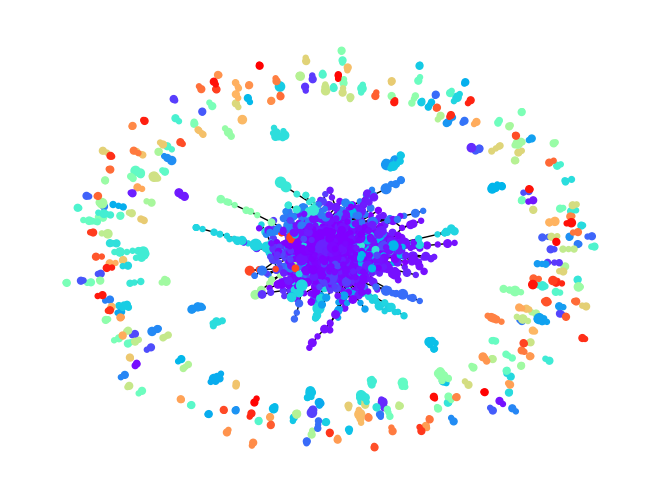

In [ ]:
# using best_partition from community_louvain to cluster these nodes into groups
from community import community_louvain
G_undirected = G.to_undirected()

# Perform community detection with a specific resolution
resolution = 1.0
partition = community_louvain.best_partition(G_undirected, resolution=resolution)

# Assign a color to each community
colors = [partition[node] for node in G_undirected.nodes]
node_size = [pagerank_scores[node] * 100000 for node in G.nodes]


# Plot the graph with communities colored
pos = nx.spring_layout(G_undirected)
nx.draw(G_undirected, pos, with_labels=False, node_color=colors, cmap=plt.cm.rainbow, node_size= node_size)
plt.show()

In [ ]:
print(f'There are {len(set(partition.values()))} communities')

There are 308 communities


<b>Observations:</b>
- **Core-Periphery Structure**: A densely connected core, indicative of a central role in the network, is surrounded by a sparsely connected periphery.

- **Communities**: Distinct clusters are visible, with nodes in the same community showing denser connections amongst themselves than with the rest of the network, suggesting a modular structure.

- **Sparse Periphery**: The peripheral nodes are spread out, possibly representing outliers or connectors between different sub-modules of the network.

- **Potential Hubs**: Nodes within the core with a high degree of connections likely act as hubs, crucial for network integrity and information flow.

- **Inter-community Bridges**: Nodes that appear between color clusters may serve as bridges, facilitating connectivity between distinct communities.

- **Isolated Nodes or Small Groups**: Isolated nodes or small clusters not integrated with the main cluster may represent less connected data points or potential sub-communities.


## Modeling

### Evaluation Metrics
ref:https://amitness.com/2020/08/information-retrieval-evaluation/

#### MRR

This metric is useful when we want our system to return the best relevant item and want that item to be at a higher position. Mathematically, this is given by:
$$ \text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i} $$

where:
- $ |Q| $ denotes the total number of queries
- $ \text{rank}_i $ denotes the rank of the first relevant result

To calculate MRR, we first calculate the reciprocal rank. It is simply the reciprocal of the rank of the first correct relevant result and the value ranges from 0 to 1.

- Example:
![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)

![image-4.png](attachment:image-4.png)

MRR doesn’t care about the position of the remaining relevant results. So, if your use-case requires returning multiple relevant results in the best possible way, MRR is not a suitable metric.

In [ ]:
def reciprocal_rank(recommended_items, relevant_items):
    """Calculate the reciprocal rank for a single query.

    Args:
        recommended_items (list): A list of recommended items.
        relevant_items (set): A set of relevant items.

    Returns:
        float: The reciprocal rank.
    """
    for idx, item in enumerate(recommended_items, 1):  # Start indexing at 1
        if item in relevant_items:
            return 1.0 / idx
    return 0  # Return 0 if no relevant item is found

def mean_reciprocal_rank(query_results, relevant_items_per_query):
    """Calculate the mean reciprocal rank for a set of queries.

    Args:
        query_results (dict): A dictionary where the key is the query id and the value is a list of recommended items.
        relevant_items_per_query (dict): A dictionary where the key is the query id and the value is a set of relevant items.

    Returns:
        float: The mean reciprocal rank.
    """
    reciprocal_ranks = []

    for query_id, recommended_items in query_results.items():
        if query_id in relevant_items_per_query:
            relevant_items = relevant_items_per_query[query_id]
            rr = reciprocal_rank(recommended_items, relevant_items)
            reciprocal_ranks.append(rr)

    return sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0

#### MAP@k


Average Precision is a metric that evaluates whether all of the ground-truth relevant items selected by the model are ranked higher or not. Unlike MRR, it considers all the relevant items.

Mathematically, it is given by:
$$ \text{AP} = \frac{\sum_{k=1}^{n} (P(k) \times \text{rel}(k))}{\text{number of relevant items}} $$

where:

- $\text{rel}(k)$ is an indicator function which is 1 when the item at rank $k$ is relevant.
- $ P(k)$ is the Precision@k metric


![image-2.png](attachment:image-2.png)

<b>MAP:</b><br>
If we want to evaluate average precision across multiple queries, we can use the MAP. It is simply the mean of the average precision for all queries. Mathematically, this is given by:

$$ \text{MAP} = \frac{1}{Q} \sum_{q=1}^{Q} AP(q) $$

where:

- $ Q$ is the total number of queries
- $ AP(q)$ is the average precision for query $q $.



In [ ]:
def average_precision_at_k(recommended_items, relevant_items, k):
    """Calculate the average precision at k for a single query.

    Args:
        recommended_items (list): A list of recommended items.
        relevant_items (set): A set of relevant items.
        k (int): The cutoff for top-k items.

    Returns:
        float: The average precision at k.
    """
    if not recommended_items:
        return 0

    score = 0.0
    num_hits = 0.0

    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / len(relevant_items) if relevant_items else 0

def mean_average_precision_at_k(query_results, relevant_items_per_query, k):
    """Calculate the mean average precision at k for a set of queries.

    Args:
        query_results (dict): A dictionary where the key is the query id and the value is a list of recommended items.
        relevant_items_per_query (dict): A dictionary where the key is the query id and the value is a set of relevant items.
        k (int): The cutoff for top-k items.

    Returns:
        float: The mean average precision at k.
    """
    average_precisions = []

    for query_id, recommended_items in query_results.items():
        if query_id in relevant_items_per_query:
            relevant_items = relevant_items_per_query[query_id]
            ap = average_precision_at_k(recommended_items, relevant_items, k)
            average_precisions.append(ap)

    return sum(average_precisions) / len(average_precisions) if average_precisions else 0

#### Recall@k

This metric gives how many actual relevant results were shown out of all actual relevant results for the query. Mathematically, this is given by:

$$ \text{Recall@k} = \frac{\text{true positives@k}}{(\text{true positives@k}) + (\text{false negatives@k})} $$

- For our example, recall@1 = 0.33 as only one of the 3 actual relevant items are present.
![image.png](attachment:image.png)
- Similarly, recall@3 = 0.67 as only two of the 3 actual relevant items are present.
![image-2.png](attachment:image-2.png)
- Thus, we can calculate the recall score for different K values.
![image-3.png](attachment:image-3.png)


In [ ]:
def recall_at_k(recommended_items, relevant_items, k):
    """
    Calculate the recall at k.

    Args:
        recommended_items (list): A list of recommended items, ordered by relevance.
        relevant_items (set): A set of relevant items.
        k (int): The cutoff rank for calculating recall.

    Returns:
        float: The recall at k.
    """
    # Identify the set of true positives among the top k recommendations
    true_positives_at_k = set(recommended_items[:k]).intersection(relevant_items)

    # The total number of relevant items
    total_relevant = len(relevant_items)

    # Recall is the fraction of relevant items that are retrieved among the top k
    if total_relevant > 0:
        return len(true_positives_at_k) / total_relevant
    else:
        return 0

def mean_recall_at_k(query_results, relevant_items_per_query, k):
    """Calculate the mean recall at k for a set of queries.

    Args:
        query_results (dict): A dictionary where the key is the query id and the value is a list of recommended items.
        relevant_items_per_query (dict): A dictionary where the key is the query id and the value is a set of relevant items.
        k (int): The cutoff for top-k items.

    Returns:
        float: The mean recall at k.
    """
    recalls = []

    for query_id, recommended_items in query_results.items():
        if query_id in relevant_items_per_query:
            relevant_items = relevant_items_per_query[query_id]
            recall = recall_at_k(recommended_items, relevant_items, k)
            recalls.append(recall)

    return sum(recalls) / len(recalls) if recalls else 0


### Node2Vec

#### Define the Model Parameters

In [ ]:
# Node2Vec settings
dimensions = 64  # Size of node embeddings
walk_length = 30 # Length of each walk
num_walks = 200  # Number of walks per node
workers = 4      # Number of workers for parallel execution


#### Train on whole grpah

In [ ]:
# Generate walks
node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)

# Train Node2Vec model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|█| 4836/4836 [00:00<00:00, 50080.25it/s
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 62.93it/s]


###### Evaluation

In [ ]:
def get_query_and_relevant(G, model, k):
    # Generate recommendations for each node
    query_results = {}
    relevant_items_per_query = {}
    for node in G.nodes():
        similar_nodes = model.wv.most_similar(node, topn=k)
        similar_node_names = [node[0] for node in similar_nodes]
        recommended_items = similar_node_names
        relevant_items = set(G.neighbors(node))
        query_results[node] = recommended_items
        relevant_items_per_query[node] = relevant_items
    return query_results, relevant_items_per_query

In [ ]:
def evaluation(query_results, relevant_items_per_query):
    # Calculate the Mean Reciprocal Rank (MRR)
    mrr = mean_reciprocal_rank(query_results, relevant_items_per_query)
    print(f"Mean Reciprocal Rank: {mrr}")

    # Calculate the Mean Average Precision@k (MAP@k)
    map_k = mean_average_precision_at_k(query_results, relevant_items_per_query, k)
    print(f"Mean Average Precision at {k}: {map_k}")

    # Calculate the Mean Recall at k (Recall@k)
    mean_recall = mean_recall_at_k(query_results, relevant_items_per_query, k)
    print(f"Mean Recall at {k}: {mean_recall}")

In [ ]:
k = 20
query_results, relevant_items_per_query = get_query_and_relevant(G, model, 20)
evaluation(query_results, relevant_items_per_query)

Mean Reciprocal Rank: 0.2281165453523365
Mean Average Precision at 20: 0.17224540785400613
Mean Recall at 20: 0.31658698626210346


#### Train and Test on splitting data

###### Split the data

In [ ]:
# Create edge list and train-test split
edges = list(G.edges())
train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=42)

# Create train graph
G_train = G.copy()
G_train.remove_edges_from(test_edges)

# For evaluation purposes, you might want to create a test graph
# This graph has all the nodes but only the test edges
G_test = nx.DiGraph()  # or nx.DiGraph() if 'G' is directed
G_test.add_nodes_from(G.nodes(data=True))
G_test.add_edges_from(test_edges)

In [ ]:
len(G_train.nodes), len(G_test.nodes)

(4836, 4836)

In [ ]:
len(G_train.edges), len(G_test.edges)

(10153, 2539)

##### Training Process(On split data)

In [ ]:
# Generate walks
node2vec1 = Node2Vec(G_train, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)

# Train Node2Vec model
model1 = node2vec1.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|█| 4836/4836 [00:00<00:00, 36602.79it/s
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 69.38it/s]


##### Evaluation on training data

In [ ]:
k = 20
query_results_train, relevant_items_per_query_train = get_query_and_relevant(G_train, model1, 20)
evaluation(query_results_train, relevant_items_per_query_train)

Mean Reciprocal Rank: 0.19509391091966036
Mean Average Precision at 20: 0.1483850117542156
Mean Recall at 20: 0.27068598459766796


##### Evaluation on testing data

In [ ]:
k = 20
query_results_test, relevant_items_per_query_test = get_query_and_relevant(G_test, model1, 20)
evaluation(query_results_test, relevant_items_per_query_test)

Mean Reciprocal Rank: 0.014621148507456903
Mean Average Precision at 20: 0.010444540571378535
Mean Recall at 20: 0.035095853108304785


### BERT + Cosine Similarity

#### Load BERT Model

In [ ]:
from transformers import BertTokenizer, BertModel
import gc
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to inference mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

#### Encoding Abstracts

In [ ]:
def encode_abstract(abstract, tokenizer, model):
    # Tokenize the abstract and prepare input for BERT
    inputs = tokenizer(abstract, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Forward pass, get model output
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)
    # Extract the last hidden state (i.e., pooled output)
    return outputs.pooler_output.detach()

#### Processing All Abstracts

In [ ]:
# abstract_dict = {}
# for node in G.nodes:
#     if node in df['source_title'].unique():
#         abstract_dict[node] = df.loc[df['source_title']==node]['source_abstract'].unique()
#     else:
#         abstract_dict[node] = df.loc[df['target_title']==node]['target_abstract'].unique()
# abstract_dict

In [ ]:
# abstract_embeddings = {}
# for key, val in abstract_dict.items():
#     abstract = val[0]
#     # Move to CPU and convert to numpy
#     abstract_embeddings[key] = encode_abstract(abstract, tokenizer, model).cpu().numpy()
#     gc.collect()  # Invoke garbage collector

In [ ]:
# abstract_embeddings['Sequence to Sequence Learning with Neural Networks'].shape

In [ ]:
# with open('abstract_embeddings.pkl', 'wb') as file:
#     pickle.dump(abstract_embeddings, file)

In [ ]:
with open('abstract_embeddings.pkl', 'rb') as file:
    abstract_embeddings = pickle.load(file)

#### Calculate Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(embeddings_dict):
    nodes = list(embeddings_dict.keys())
    num_nodes = len(nodes)
    similarity_matrix = np.zeros((num_nodes, num_nodes))

    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            if i != j:
                # Compute cosine similarity and extract the scalar value
                sim_score = cosine_similarity(
                    embeddings_dict[node_i].reshape(1, -1),
                    embeddings_dict[node_j].reshape(1, -1)
                )[0][0]  # Extract the scalar similarity score
                similarity_matrix[i][j] = sim_score

    return nodes, similarity_matrix

In [ ]:
# nodes, similarity_matrix = compute_similarity(abstract_embeddings)
# np.savez('similarity_matrix.npz', array_name=similarity_matrix)

In [ ]:
nodes = list(abstract_embeddings.keys())
loaded_data = np.load('similarity_matrix.npz')
similarity_matrix = loaded_data['array_name']

In [ ]:
similarity_matrix.shape

(4836, 4836)

#### Get Topk similar nodes and evaluate

In [ ]:
def get_top_k_similar_nodes(similarity_matrix, node_names, k):
    top_k_indices = np.argsort(-similarity_matrix, axis=1)[:, 1:k+1]  # Get top k indices, exclude self-similarity
    top_k_similar_nodes = {}

    for i, indices in enumerate(top_k_indices):
        node = node_names[i]
        similar_nodes = [node_names[j] for j in indices]
        top_k_similar_nodes[node] = similar_nodes

    return top_k_similar_nodes


In [ ]:
k = 20  # Number of top similar nodes to find
top_k_similar_nodes = get_top_k_similar_nodes(similarity_matrix, nodes, k)

In [ ]:
top_k_similar_nodes

{'Sequence to Sequence Learning with Neural Networks': ['Cold Fusion: Training Seq2Seq Models Together with Language Models',
  'Character-Aware Neural Language Models',
  'Vocabulary Manipulation for Neural Machine Translation',
  'Multi-Task Learning of Keyphrase Boundary Classification',
  'Language Recognition using Random Indexing',
  'Grid Long Short-Term Memory',
  'Compositional Morphology for Word Representations and Language Modelling',
  'A Fully Convolutional Neural Network for Speech Enhancement',
  'Tree-to-Sequence Attentional Neural Machine Translation',
  'CRF Autoencoder for Unsupervised Dependency Parsing',
  'Representation learning for very short texts using weighted word embedding aggregation',
  'Deep Supervised and Convolutional Generative Stochastic Network for Protein Secondary Structure Prediction',
  'Character-Level Incremental Speech Recognition with Recurrent Neural Networks',
  'Effective Use of Word Order for Text Categorization with Convolutional Neura

In [ ]:
def get_relevant(G):
    # Generate recommendations for each node
    relevant_items_per_query = {}
    for node in G.nodes():
        relevant_items = set(G.neighbors(node))
        relevant_items_per_query[node] = relevant_items
    return relevant_items_per_query

In [ ]:
evaluation(top_k_similar_nodes, get_relevant(G))

Mean Reciprocal Rank: 0.00901005507567459
Mean Average Precision at 20: 0.0028425614669239127
Mean Recall at 20: 0.010551529809216621
